## Валидация моделей классификации

Данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


np.set_printoptions(precision=4)

df_source = pd.read_csv(
    'data/client_segmentation.csv', 
    dtype={'call_diff': np.float32, 'call_diff': np.float32, 'traffic_diff': np.float32, 'customes_class': np.uint16}
)
df_source[(df_source.customes_class==2) & (df_source.call_diff>1.1)] = 0
df_source[(df_source.customes_class==2) & (df_source.call_diff<=1.1)] = 1
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

df_source.head(5)

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0
1,1.000000,1.000000,1.000000,1
2,-0.841503,0.846665,0.727606,0
3,1.389749,0.390911,1.789246,1
4,1.000000,1.000000,1.000000,1


Найдем лучший классификатор для одного размера тестовой выборки:

In [2]:
from sklearn.tree  import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

classifiers = [
    DecisionTreeClassifier().fit(X_train, y_train),
    GaussianNB().fit(X_train, y_train),
    KNeighborsClassifier().fit(X_train, y_train),
    LogisticRegression().fit(X_train, y_train),
    RandomForestClassifier().fit(X_train, y_train)
]
y_pred = [cl.predict(X_test) for cl in classifiers]

f1_results = [f1_score(y_test, y_pred[i]) for i in range(len(y_pred))]


for i in range(len(y_pred)):
    print(str(classifiers[i])[:-2], '-', f1_results[i])

best_score = f1_results.index(max(f1_results))  # индекс массива лучшего классификатора
print(f'\nЛучший классификатор по метрике f1-score: {str(classifiers[best_score])[:-2]} - {max(f1_results)}')

DecisionTreeClassifier - 0.9583333333333334
GaussianNB - 0.9166666666666666
KNeighborsClassifier - 0.9583333333333334
LogisticRegression - 0.9583333333333334
RandomForestClassifier - 0.9583333333333334

Лучший классификатор по метрике f1-score: DecisionTreeClassifier - 0.9583333333333334


Из-за небольшого количества данных классификаторы оказываются практически одинаково эффективны, а сама эффективность гораздо больше зависит от размера тестовой выборки, чем от классификатора.
Найдем лучший классификатор по метрике f1-score в диапазоне значений размера тестовой выборки (от 0.2 до 0.5):

In [3]:
y_pred_set = []  # запишем значения предсказаний
y_test_set = []  # и реальных значений для всех выборок

for tsize in range(20, 51):  # запускаем цикл по нужному диапазону размера тестовой выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize/100, random_state=42)

    classifiers = [
        DecisionTreeClassifier().fit(X_train, y_train),
        GaussianNB().fit(X_train, y_train),
        KNeighborsClassifier().fit(X_train, y_train),
        LogisticRegression().fit(X_train, y_train),
        RandomForestClassifier().fit(X_train, y_train)
    ]                                             # массив классификаторов для тестирования
    try:
        y_pred = [cl.predict(X_test) for cl in classifiers]
    except ValueError:
        print(f'Ошибка в выборке {tsize}')
        
    y_pred_set.append(y_pred)  # добавляем значения в массив
    y_test_set.append(y_test)

Получим средние значения метрики для массива по выборкам у тестируемых классификаторов

In [4]:
set_length = len(y_pred_set[0])
f1_summary = [0 for _ in range(set_length)]

for cnum in range(len(y_pred_set)):
    for i in range(set_length):
        f1_summary[i] += f1_score(y_test_set[cnum], y_pred_set[cnum][i]) / len(y_pred_set)
        
f1_summary

[0.9661074690850271,
 0.943366378980873,
 0.9679715881108089,
 0.9701533833844247,
 0.9679715881108089]

Получим значение наилучшего классификатора по средним метрикам:

In [5]:
best_score = f1_summary.index(max(f1_summary))  # индекс массива лучшего классификатора
print(f'Лучший классификатор по метрике f1-score: {str(classifiers[best_score])[:-2]} - {max(f1_summary)}')

Лучший классификатор по метрике f1-score: LogisticRegression - 0.9701533833844247


## Валидация моделей линейной регрессии

Пользуясь методом .score подберите наилучшее значение степени полинома

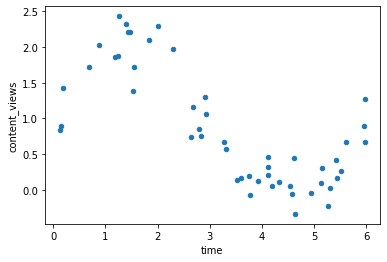

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('data/content_views_toy_set.csv', encoding='utf8')
df.plot.scatter(x='time', y='content_views')
plt.show()

X = df['time'].values
y = df['content_views'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression().fit(X_train.reshape(-1, 1), y_train)

In [7]:
def generate_degrees(source_data: list, degree: int):
    """Функция, которая принимает на вход одномерный массив, а возвращает n-мерный
    Для каждой степени от 1 до degree возводим x в эту степень
    """
    return np.array([
          source_data**n for n in range(1, degree + 1)  
    ]).T

Определим наилучшую степень полинома и визуализируем значение score:

Наилучшее значение степени полинома: 3
score = 0.9313123641187704


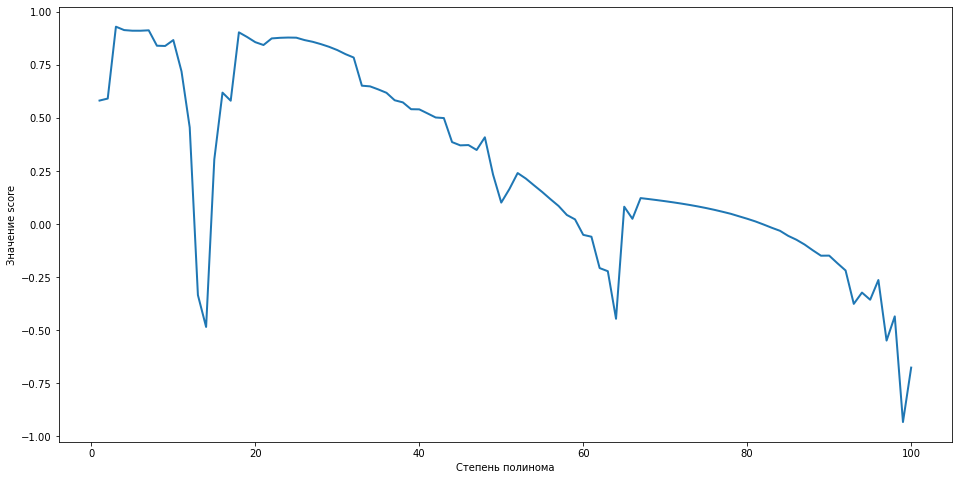

In [10]:
scores = []
start = 1  # начальная степень полинома
stop = 100  # конечная степень

for i in range(start, stop + 1):
    X_train_i = generate_degrees(X_train, i)
    X_test_i = generate_degrees(X_test, i)
    reg_i = LinearRegression().fit(X_train_i, y_train)
    
    scores.append(reg_i.score(X_test_i, y_test))

best_pol = scores.index(max(scores)) + start  # лучшее значение полинома
print(f'Наилучшее значение степени полинома: {best_pol}\nscore = {max(scores)}')

indexes = np.arange(len(scores)) + 1
plt.figure(figsize=(16, 8))
plt.plot(indexes, scores, linewidth=2)
plt.xlabel('Степень полинома')
plt.ylabel('Значение score')
plt.show()

Построим график с наилучшей степенью полинома:

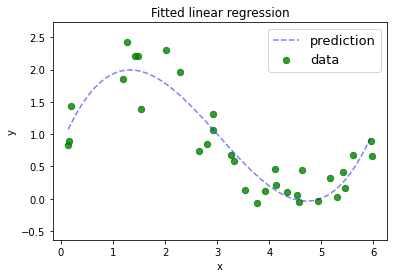

In [11]:
X_train_best = generate_degrees(X_train, best_pol)
X_test_best = generate_degrees(X_test, best_pol)
reg_best = LinearRegression().fit(X_train_best, y_train)

# строим график
margin = 0.3
support = np.arange(X.min(), X.max(), step=0.1)

X_test_support = generate_degrees(support, best_pol)
y_hat = reg_best.predict(X_test_support)

plt.plot(support, y_hat, 'b--', alpha=0.5, label='prediction')
plt.scatter(X_train, y_train, 40, 'g', 'o', alpha=0.8, label='data')
plt.xlim(X.min() - margin, X.max() + margin)
plt.ylim(y.min() - margin, y.max() + margin)
plt.legend(loc='upper right', prop={'size': 13})
plt.title('Fitted linear regression')
plt.xlabel('x')
plt.ylabel('y')
plt.show()